In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch

In [ ]:
def estimate_parameters(calibration_df):
    calibration_images = calibration_df1['image'].values
    calibration_temperatures = np.vstack((calibration_df1['t_fpa'].values, calibration_df1['t_cn'].values)).T
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)
    
    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).cuda()
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).cuda()
    
    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.cuda()

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).cuda()], dim=1)
    
    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]
    
    # Reshape back to original image shape
    offsets = offsets.view(height, width).cpu().numpy()
    responsivities = responsivities.view(height, width, -1).cpu().numpy()
    
    return offsets, responsivities





In [ ]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).cuda()
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).cuda()
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).cuda()
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).cuda()
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).cuda()
    
    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)
    
    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value
    
    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.cpu().numpy()
    
    return corrected_image

In [ ]:
def apply_inverse_correction(corrected_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    corrected_image_tensor = torch.tensor(corrected_image, dtype=torch.float32).cuda()
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).cuda()
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).cuda()
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).cuda()
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).cuda()

    height, width = corrected_image_tensor.shape
    original_image_tensor = torch.zeros_like(corrected_image_tensor)

    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor

    # Apply inverse correction
    original_image_tensor = corrected_image_tensor + expected_value

    # Convert the result back to a numpy array if needed
    original_image = original_image_tensor.cpu().numpy()

    return original_image


In [ ]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [ ]:
def generate_frames(num_frames, height, width):
    frames = []
    for i in range(num_frames):
        frame = np.zeros((height, width), dtype=np.uint8)
        bar_position = i * (width // num_frames)
        frame[:, bar_position:bar_position + (width // num_frames)] = 255
        frames.append(frame)
    return frames

In [ ]:
frames = generate_frames(60,480,640)

In [ ]:
def applier(calibration_df,scene_df):
    
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()

    # Process each scene image
    corrected_scene_images = []
    for index, row in scene_df.iterrows():
        scene_image = row['image']
        scene_temp = row['t_fpa']
        
        corrected_image = apply_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)
        
        

    # Convert corrected_scene_images to numpy array
    return np.array(corrected_scene_images)

In [ ]:
def inverse_applier(calibration_df, scene_images):
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()
    scene_temp = 20
    corrected_scene_images = []
    for scene_image in scene_images:
        corrected_image = apply_inverse_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)

    return np.array(corrected_scene_images)


In [ ]:
def t_test_filter_torch(image_list, significance_level=0.05):
    # Convert list of arrays to a single tensor
    images_tensor = torch.tensor(np.array(image_list), dtype=torch.float32).cuda()
    num_images, height, width = images_tensor.shape
    
    # Compute mean and standard deviation for each pixel
    mean_tensor = images_tensor.mean(dim=0)
    std_tensor = images_tensor.std(dim=0, unbiased=False)
    
    # Avoid division by zero by setting zero std to a very small number
    std_tensor[std_tensor == 0] = 1e-10
    
    # Calculate t-statistics
    t_stat_tensor = (images_tensor - mean_tensor) / (std_tensor / torch.sqrt(torch.tensor(num_images, dtype=torch.float32).cuda()))
    
    # Calculate p-values
    p_values_tensor = 2 * (1 - torch.distributions.Normal(0, 1).cdf(torch.abs(t_stat_tensor)))
    
    # Identify pixels that do not change significantly over time
    mask = (p_values_tensor > significance_level).all(dim=0)
    
    # Compute the mean values only for the non-changing pixels
    mask_expanded = mask.unsqueeze(0).expand_as(images_tensor)
    masked_images_tensor = images_tensor * mask_expanded.float()
    sum_mask = mask.sum(dim=0).float()
    sum_mask[sum_mask == 0] = float('nan')  # Avoid division by zero
    masked_mean_values = masked_images_tensor.sum(dim=0) / sum_mask
    
    return masked_mean_values.cpu().numpy()







In [ ]:
scene_df1 = pd.read_hdf('car_scene.hdf5')
scene_df2 = pd.read_hdf('car_scene2.hdf5')
scene_df3 = pd.read_hdf('car_scene3.hdf5')

In [ ]:
car_calibration_df1 = pd.read_hdf("car_calibration_set_1.hdf5")
car_calibration_df2 = pd.read_hdf("car_calibration_set_2.hdf5")

calibration_df1 = pd.read_hdf("calibration_set_1.hdf5")
calibration_df2 = pd.read_hdf("calibration_set_2.hdf5")

In [ ]:
offset, gain = estimate_parameters(car_calibration_df1)
avg_black_body_temp = 0
scene_temp = 60
array = np.full((480, 640), 1000)
#array = np.random.random((480,640))
corrected = apply_inverse_correction(array, offset, gain, scene_temp, avg_black_body_temp )

plt.imshow(corrected, cmap='gray')
plt.colorbar()
plt.show()


In [ ]:
bar_noisy = inverse_applier(calibration_df1, frames)
save_video_from_images(bar_noisy, "noisy_bar.avi")
save_video_from_images(frames,"bar.avi")

In [ ]:
cals = [calibration_df1, calibration_df2]
scenes =[scene_df1, scene_df2, scene_df3]
for i, c in enumerate(cals):
    for j, s in enumerate(scenes):
        name = f"car_cal_{i+1}_scene_{j+1}.avi"
        video = applier(c,s)
        save_video_from_images(video, name)




In [ ]:
for i, s in enumerate(scenes):
    name = f"car_origin_{i+1}.avi"
    save_video_from_images(s["image"], name)

In [ ]:
np.stack(scene_df1["image"].values).shape

In [ ]:
def median_denoised_df(scene_df):

    baseline = np.median(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline
    

In [ ]:
def median_denoised_video(scene):

    baseline = np.median(scene, axis =0)

    return scene-baseline

In [ ]:
import numpy as np

def compute_mse(image1, image2):
    """
    Compute the Mean Squared Error between two images.
    
    Parameters:
    image1, image2 (numpy.ndarray): 2D arrays of the same shape
    
    Returns:
    float: Mean Squared Error between the two images
    """
    return np.mean((image1 - image2) ** 2)

def find_most_different_frames(video, top_percentage=0.1):
    """
    Find the most different frames in the video based on MSE.
    
    Parameters:
    video (numpy.ndarray): 3D array of shape (num_frames, height, width)
    top_percentage (float): Percentage of frames to select
    
    Returns:
    numpy.ndarray: 3D array of the selected frames
    """
    num_frames, height, width = video.shape
    mse_matrix = np.zeros((num_frames, num_frames))
    
    # Compute MSE between each pair of frames
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            mse_matrix[i, j] = compute_mse(video[i], video[j])
            mse_matrix[j, i] = mse_matrix[i, j]
    
    # Compute the average MSE for each frame
    avg_mse = np.mean(mse_matrix, axis=1)
    
    # Find the indices of the top_percentage most different frames
    num_top_frames = int(top_percentage * num_frames)
    top_frame_indices = np.argsort(avg_mse)[-num_top_frames:]
    
    # Select the most different frames
    most_different_frames = video[top_frame_indices]
    
    return most_different_frames

def extract_noise_pattern(video):
    """
    Extract the fixed noise pattern from a video.
    
    Parameters:
    video (numpy.ndarray): 3D array of shape (num_frames, height, width)
    
    Returns:
    numpy.ndarray: 2D array of shape (height, width) representing the fixed noise pattern
    """
    # Find the most different frames
    most_different_frames = find_most_different_frames(video)
    
    # Calculate the median across the selected frames
    noise_pattern = np.median(most_different_frames, axis=0)
    
    return noise_pattern

def remove_noise_from_video(video, noise_pattern):
    """
    Remove the fixed noise pattern from a video.
    
    Parameters:
    video (numpy.ndarray): 3D array of shape (num_frames, height, width)
    noise_pattern (numpy.ndarray): 2D array of shape (height, width) representing the fixed noise pattern
    
    Returns:
    numpy.ndarray: 3D array of shape (num_frames, height, width) with the noise removed
    """
    # Ensure noise pattern is the same size as the video frames
    if noise_pattern.shape != video.shape[1:]:
        raise ValueError("Noise pattern dimensions do not match video frame dimensions")
    
    # Subtract the noise pattern from each frame
    cleaned_video = video - noise_pattern
    
    # Clip values to ensure they are within valid range (0-255 for 8-bit images)
    cleaned_video = np.clip(cleaned_video, 0, 255)
    
    return cleaned_video.astype(np.uint8)


In [ ]:
import torch
import numpy as np

def extract_and_remove_noise_MSE(video, device='cuda'):
    """
    Extract and remove the fixed noise pattern from a video using PyTorch for acceleration.
    
    Parameters:
    video (numpy.ndarray): 3D array of shape (num_frames, height, width)
    device (str): Device to use for computation ('cuda' or 'cpu')
    
    Returns:
    numpy.ndarray: 3D array of shape (num_frames, height, width) with the noise removed
    """
    # Convert video to torch tensor and move to the specified device
    video_tensor = torch.tensor(video, dtype=torch.float32, device=device)
    
    num_frames, height, width = video_tensor.shape
    
    # Compute MSE matrix
    mse_matrix = torch.zeros((num_frames, num_frames), device=device)
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            mse = torch.mean((video_tensor[i] - video_tensor[j]) ** 2)
            mse_matrix[i, j] = mse
            mse_matrix[j, i] = mse
    
    # Compute the average MSE for each frame
    avg_mse = torch.mean(mse_matrix, dim=1)
    
    # Find the indices of the top 10% most different frames
    num_top_frames = int(0.5 * num_frames)
    top_frame_indices = torch.topk(avg_mse, num_top_frames, largest=True).indices
    
    # Select the most different frames
    most_different_frames = video_tensor[top_frame_indices]
    
    # Calculate the median across the selected frames
    noise_pattern = torch.median(most_different_frames, dim=0).values
    
    # Subtract the noise pattern from each frame
    cleaned_video_tensor = video_tensor - noise_pattern
    

    
    # Move the cleaned video back to CPU and convert to numpy array
    cleaned_video = cleaned_video_tensor.cpu().numpy().astype(np.uint8)
    
    return cleaned_video


In [ ]:
def selective_median_noise_removal(video, percentage=0.9):
    num_frames, height, width = video.shape

    # Calculate mean absolute deviation (MAD) for each frame
    mean_frame = np.mean(video, axis=0)
    mad = np.mean(np.abs(video - mean_frame), axis=(1, 2))

    # Select frames with the least variation (highest percentage defined by 'percentage')
    num_selected_frames = int(percentage * num_frames)
    selected_indices = np.argsort(mad)[:num_selected_frames]

    selected_frames = video[selected_indices]

    # Calculate the median across the selected frames
    noise_pattern = np.median(selected_frames, axis=0)

    # Subtract the noise pattern from each frame
    cleaned_video = video - noise_pattern

    # Normalize the cleaned video to ensure proper range
    min_val = cleaned_video.min(axis=(1, 2), keepdims=True)
    max_val = cleaned_video.max(axis=(1, 2), keepdims=True)
    cleaned_video = (cleaned_video - min_val) / (max_val - min_val) * 255

    # Clip values to ensure they are within valid range (0-255 for 8-bit images)
    cleaned_video = np.clip(cleaned_video, 0, 255).astype(np.uint8)

    return cleaned_video


In [ ]:
def hybrid_noise_removal(video, device='cuda'):
    video_tensor = torch.tensor(video, dtype=torch.float32, device=device)
    median_pattern = torch.median(video_tensor, dim=0).values
    mean_pattern = torch.mean(video_tensor, dim=0)
    noise_pattern = 0.3 * median_pattern + 0.7 * mean_pattern
    cleaned_video_tensor = video_tensor - noise_pattern
    cleaned_video_tensor = torch.clamp(cleaned_video_tensor, 0, 255)
    cleaned_video = cleaned_video_tensor.cpu().numpy().astype(np.float32)
    return cleaned_video




In [ ]:
video = np.stack(scene_df2["image"].values)



In [192]:

md = median_denoised_video(video)
mdd = median_denoised_video(md)

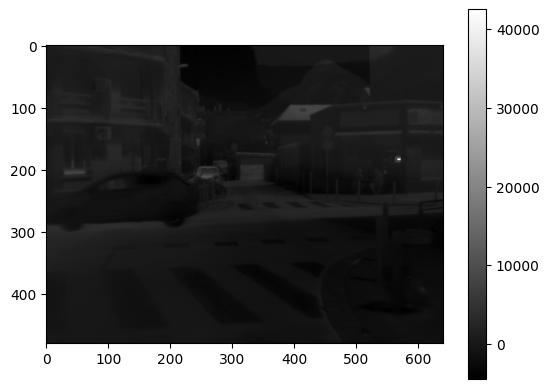

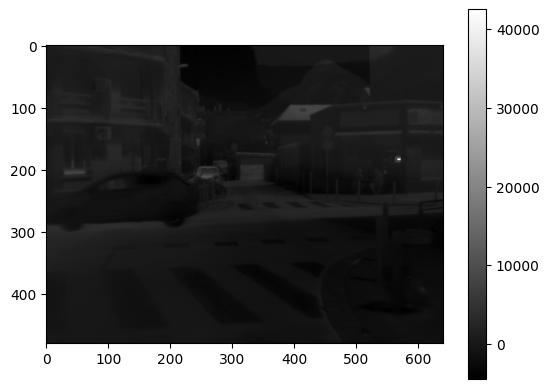

In [193]:
plt.imshow(md[40], cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(mdd[40], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
all_scenes = [scene_df1,scene_df2,scene_df3]

for i, scene in enumerate(all_scenes):
    name = f"MSE_car_scene_{i+1}.avi"
    noise = extract_noise_pattern(np.stack(scene["image"].values))
    cleaned = remove_noise_from_video(video, noise)
    save_video_from_images(cleaned, name)

